In [1]:
# @title Step 2: Load Data (Example: CSV with 'title', 'description')
import pandas as pd
import torch
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.decomposition import LatentDirichletAllocation
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics import adjusted_rand_score, adjusted_mutual_info_score
import sklearn.cluster as cluster

import umap
import matplotlib.pyplot as plt
torch.cuda.is_available()
torch.cuda.empty_cache()

/home/suna/anaconda3/envs/papers_scrap/lib/python3.12/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
df = pd.read_csv('../data/filtered_dataset.csv')
print(f'Shape of the dataset: {df.shape}')
df.head()

Shape of the dataset: (1200, 18)


,title,authors,year,description,url,citations,clean_title,type,cluster,word_count,char_count,category,domain,publisher,path,query_params,doi,extension
0,The finance uncertainty multiplier,"I Alfaro, N Bloom, X Lin",2024.0,We show how real and financial frictions ampli...,https://www.journals.uchicago.edu/doi/full/10....,407,uncertainty multiplier,NaN,0,2,21,finance,journals.uchicago.edu,University of Chicago Press,/doi/full/10.1086/726230,{},10.1086/726230,NaN
1,The finance of local government,NP Hepworth,2024.0,Originally published in 1970 this book quickly...,https://books.google.com/books?hl=en&lr=&id=kF...,176,local government,BOOK,0,2,15,finance,books.google.com,Google Books,/books,"{'hl': ['en'], 'id': ['kFczEQAAQBAJ'], 'oi': [...",NaN,NaN
2,Mathematics for economics and finance: methods...,"M Anthony, N Biggs",2024.0,"Accessible, concise, and interactive, this boo...",https://books.google.com/books?hl=en&lr=&id=xW...,95,mathematics economics methods modelling,BOOK,0,4,36,finance,books.google.com,Google Books,/books,"{'hl': ['en'], 'id': ['xWAJEQAAQBAJ'], 'oi': [...",NaN,NaN
3,The technology of decentralized finance (DeFi),"R Auer, B Haslhofer, S Kitzler, P Saggese, F V...",2024.0,Decentralized Finance (DeFi) is a new financia...,https://link.springer.com/article/10.1007/s425...,91,technology decentralized defi,NaN,3,3,27,finance,link.springer.com,Springer,/article/10.1007/s42521-023-00088-8,{},10.1007/s42521,NaN
4,Personal finance,VL Bajtelsmit,2024.0,"Personal Finance, 3rd Edition offers essential...",https://books.google.com/books?hl=en&lr=&id=SN...,36,personal,BOOK,7,1,8,finance,books.google.com,Google Books,/books,"{'hl': ['en'], 'id': ['SNjzEAAAQBAJ'], 'oi': [...",NaN,NaN


In [3]:
%%time
from transformers import AutoTokenizer, AutoModel
import torch
import numpy as np
import gc  # for garbage collection
import pandas as pd

# Load model and tokenizer
tokenizer = AutoTokenizer.from_pretrained('allenai/specter')
model = AutoModel.from_pretrained('allenai/specter')
device = torch.device("cuda:0")
model.to(device=device)

# Prepare the dataset
df = df.fillna("")  # Handle NaN values

# Number of chunks to divide the dataset into
num_chunks = 20
chunk_size = len(df) // num_chunks
if len(df) % num_chunks != 0:
    chunk_size += 1  # Ensure we cover all samples

# Initialize array to store all embeddings
all_embeddings = []
all_indices = []  # To keep track of the original indices

# Process data in chunks
for i in range(num_chunks):
    print(f"Processing chunk {i+1}/{num_chunks}")
    
    # Get the current chunk
    start_idx = i * chunk_size
    end_idx = min((i + 1) * chunk_size, len(df))
    chunk_df = df.iloc[start_idx:end_idx]
    
    # Store original indices
    all_indices.extend(chunk_df.index.tolist())
    
    # Concatenate title and description for the current chunk
    title_abs = (chunk_df['clean_title'] + tokenizer.sep_token + chunk_df['description']).tolist()
    
    # Preprocess the input
    inputs = tokenizer(title_abs, padding=True, truncation=True, 
                       return_tensors="pt", max_length=512).to(device)
    
    # Get embeddings
    with torch.no_grad():  # Disable gradient calculation to save memory
        result = model(**inputs)
        chunk_embeddings = result.last_hidden_state[:, 0, :].cpu().numpy()  # Move to CPU and convert to numpy
    
    # Append to our list of all embeddings
    all_embeddings.append(chunk_embeddings)
    
    # Clear GPU cache
    del inputs, result, chunk_embeddings
    torch.cuda.empty_cache()
    gc.collect()

# Concatenate all chunks of embeddings
embeddings = np.vstack(all_embeddings)

print(f"Final embeddings shape: {embeddings.shape}")

# Create a DataFrame with the embeddings
# Convert embeddings to DataFrame where each column is a dimension
embedding_df = pd.DataFrame(
    embeddings,
    columns=[f"dim_{i}" for i in range(embeddings.shape[1])]
)

# Add original index for joining with original data later
embedding_df['original_index'] = all_indices

# Save to CSV
embedding_file = "document_embeddings.csv"
embedding_df.to_csv(embedding_file, index=False)

print(f"Embeddings saved to {embedding_file}")

Processing chunk 1/20
Processing chunk 2/20
Processing chunk 3/20
Processing chunk 4/20
Processing chunk 5/20
Processing chunk 6/20
Processing chunk 7/20
Processing chunk 8/20
Processing chunk 9/20
Processing chunk 10/20
Processing chunk 11/20
Processing chunk 12/20
Processing chunk 13/20
Processing chunk 14/20
Processing chunk 15/20
Processing chunk 16/20
Processing chunk 17/20
Processing chunk 18/20
Processing chunk 19/20
Processing chunk 20/20
Final embeddings shape: (1200, 768)
Embeddings saved to document_embeddings.csv
CPU times: user 7.15 s, sys: 1.12 s, total: 8.27 s
Wall time: 9.67 s


In [52]:
# To load the embeddings later
loaded_embeddings = pd.read_csv("document_embeddings.csv")

# Extract just the embedding columns
embedding_columns = [col for col in loaded_embeddings.columns if col.startswith("dim_")]
embeddings_np = loaded_embeddings[embedding_columns].values
print(f"Loaded embeddings shape: {embeddings_np.shape}")

Loaded embeddings shape: (1200, 768)


In [53]:
# @title Step 4: Build FAISS Index for Fast Similarity Search
import faiss
import numpy as np

# Normalize for cosine similarity
# embeddings_np is of type float32 before normalizing
embeddings_np = embeddings_np.astype('float32') 
# Ensure array is C-contiguous before normalizing
embeddings_np = np.ascontiguousarray(embeddings_np, dtype='float32')

faiss.normalize_L2(embeddings_np)

# Create FAISS index
index = faiss.IndexFlatIP(embeddings_np.shape[1])  # Inner product = cosine similarity; Computes a residual vector after indexing encoding.
index.add(embeddings_np)

In [54]:
# @title Step 5: Recommend Similar Papers
def recommend_paper(query_title, query_description, top_k=3):
  # Concatenate with separator token, similar to how we processed the dataset
  query_text = query_title + tokenizer.sep_token + query_description
  # Tokenize the query text
  query_inputs = tokenizer(query_text, padding=True, truncation=True, return_tensors="pt", max_length=512).to(device=torch.device("cuda:0"))
  # Get the embeddings
  with torch.no_grad():
    query_result = model(**query_inputs)
  # Extract the embedding from the first token
  query_embedding = query_result.last_hidden_state[:, 0, :].cpu().detach().numpy().astype('float32')
  faiss.normalize_L2(query_embedding)

  distances, indices = index.search(query_embedding, top_k)
  
  print(f"🔍 Recommendations for '{query_title}':")
  for i, idx in enumerate(indices[0]):
    print(f"{i+1}. {df.iloc[idx]['title']} (Citations: {df.iloc[idx].get('citations', 'N/A')})")
    print(f"   {df.iloc[idx]['description'][:100]}...\n")

# Test with a sample query
recommend_paper(
    query_title="Air pollutants, economic growth and public health: implications for sustainable development in OECD countries",
    query_description="and economic growth. Moreover, most studies use GDP as a proxy for economic growth; current … used as proxies for economic growth in the literature, and the current study fills this gap.",
    top_k=10
)

🔍 Recommendations for 'Air pollutants, economic growth and public health: implications for sustainable development in OECD countries':
1. Air pollutants, economic growth and public health: implications for sustainable development in OECD countries (Citations: 116)
   … and economic growth. Moreover, most studies use GDP as a proxy for economic growth; 
current … use...

2. Impact of China's economic growth and energy consumption structure on atmospheric pollutants: Based on a panel threshold model (Citations: 118)
   … sustainable economic development while economic growth is … structure, energy intensity, 
economic...

3. Urbanization, economic growth, energy consumption, and CO2 emissions: Empirical evidence from countries with different income levels (Citations: 569)
   … While the link between urbanization, economic growth, … the link between urbanization, 
economic d...

4. Dynamic relationship among environmental regulation, innovation, CO2 emissions, population, and economic gro

# UMAP: Uniform Manifold Approximation and Projection

UMAP is a dimensionality reduction technique that:

- **Transforms high-dimensional data** into a lower-dimensional space (in this case, from many dimensions to just 2)
- **Preserves both local and global structure** of the data
- **Shows relationships between items** by placing similar items closer together

## What UMAP does in this code:

1. Takes the paper embeddings (`embeddings_np`), which are likely high-dimensional vectors (possibly 300-1000+ dimensions)
2. Reduces them to just 2 dimensions while trying to maintain their relative relationships
3. Creates a visualization where:
   - Papers with similar content appear close together
   - Papers with different content appear far apart
   - Clusters may indicate papers on related topics

UMAP is particularly useful for visualizing complex embedding spaces that would otherwise be impossible to interpret directly due to their high dimensionality.

/home/suna/anaconda3/envs/papers_scrap/lib/python3.12/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/home/suna/anaconda3/envs/papers_scrap/lib/python3.12/site-packages/umap/umap_.py:1952: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(


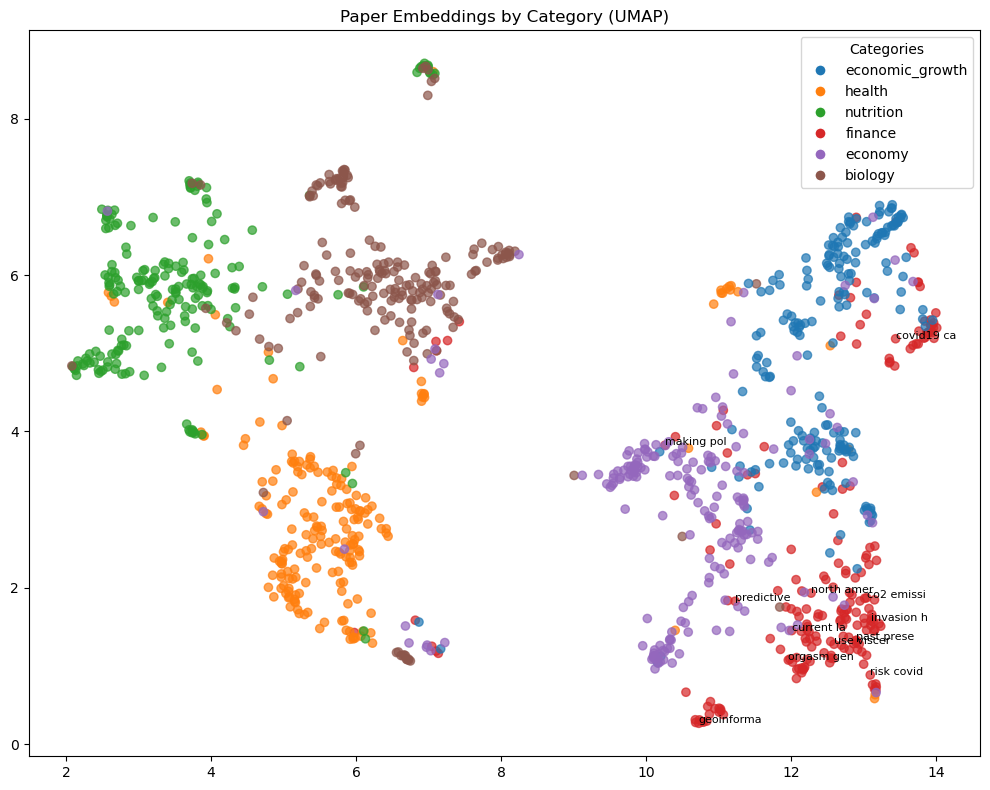

In [42]:
# @title (Optional) Step 6: Visualize with UMAP

reducer = umap.UMAP(random_state=42)
umap_embeds = reducer.fit_transform(embeddings_np)

length = 1200

# Get categories for coloring
categories = df.head(length)['category'].tolist()
unique_categories = list(set(categories))
category_to_color = {cat: plt.cm.tab10(i) for i, cat in enumerate(unique_categories)}
colors = [category_to_color[cat] for cat in categories]

# Create scatter plot with category colors
plt.figure(figsize=(10, 8))
scatter = plt.scatter(umap_embeds[0:length, 0], umap_embeds[0:length, 1], c=colors, alpha=0.7)

# Add title annotations
for i, title in enumerate(df.sample(frac=0.01)['clean_title']):
  plt.annotate(title[:10], (umap_embeds[i, 0], umap_embeds[i, 1]), fontsize=8)

# Add legend
legend_elements = [plt.Line2D([0], [0], marker='o', color='w', 
                markerfacecolor=category_to_color[cat], label=cat, markersize=8)
          for cat in unique_categories]
plt.legend(handles=legend_elements, title="Categories", loc="best")

plt.title("Paper Embeddings by Category (UMAP)")
plt.tight_layout()
plt.show()

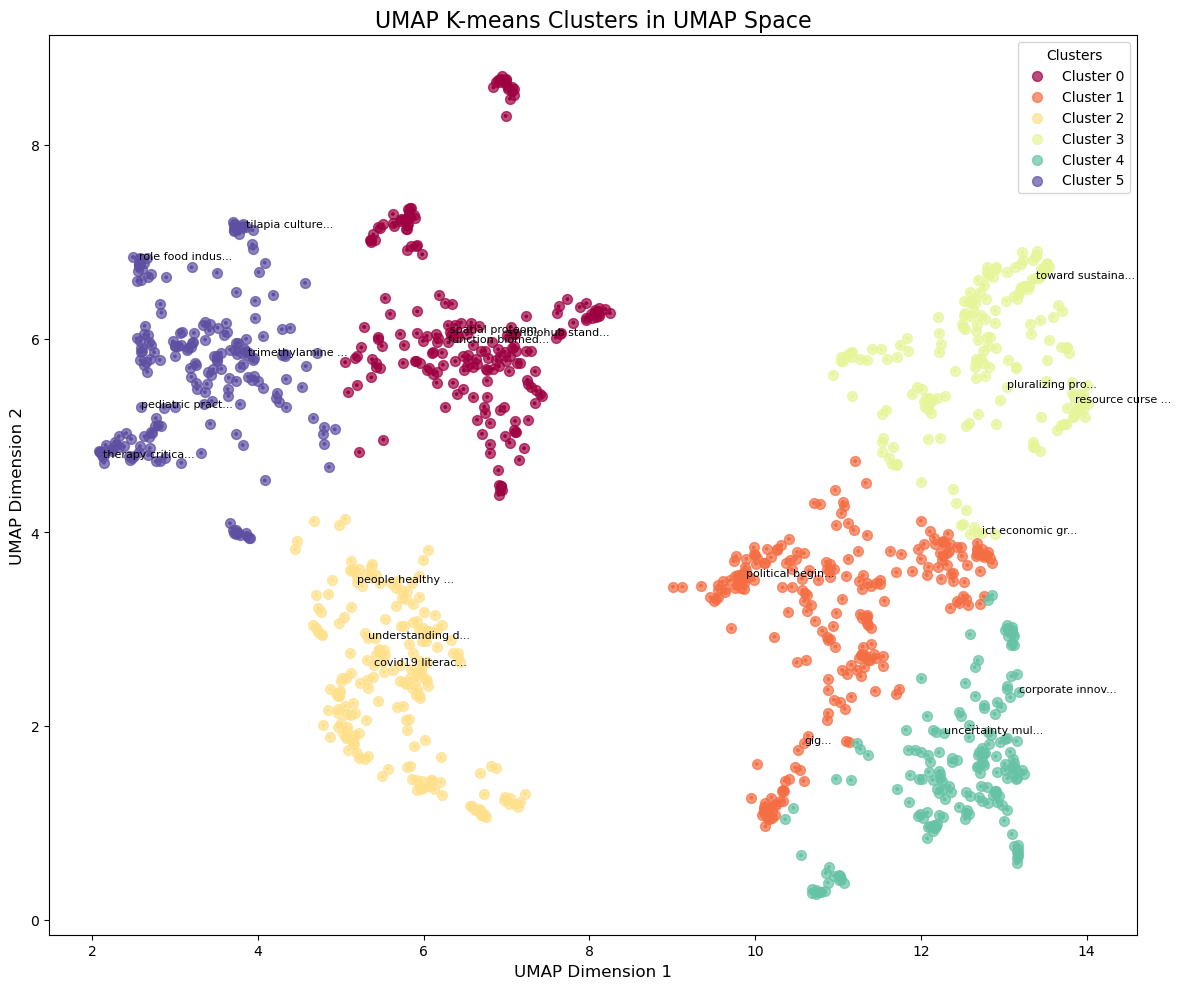

In [43]:
kmeans_labels = cluster.KMeans(n_clusters=6, random_state=42).fit_predict(umap_embeds)

plt.figure(figsize=(12, 10))

unique_clusters = np.unique(kmeans_labels)
colors = plt.cm.Spectral(np.linspace(0, 1, len(unique_clusters)))

# Create a scatter plot for each cluster
for cluster_id, color in zip(unique_clusters, colors):
    # Get indices for current cluster
    mask = kmeans_labels == cluster_id
    # Plot points in current cluster
    plt.scatter(umap_embeds[mask, 0], umap_embeds[mask, 1],
                c=[color], s=50, alpha=0.7, label=f'Cluster {cluster_id}')

# Add titles for a few points for context
num_titles = 20  # Number of titles to show
step = len(df) // num_titles
for i in range(0, len(df), step):
    if i < len(umap_embeds):  # Make sure we don't go out of bounds
        plt.annotate(df.iloc[i]['clean_title'][:15] + "...",
                    (umap_embeds[i, 0], umap_embeds[i, 1]),
                    fontsize=8)

plt.scatter(umap_embeds[:, 0], umap_embeds[:, 1], c=kmeans_labels, s=3, cmap='Spectral');
plt.title('UMAP K-means Clusters in UMAP Space', fontsize=16)
plt.xlabel('UMAP Dimension 1', fontsize=12)
plt.ylabel('UMAP Dimension 2', fontsize=12)

# Create a ScalarMappable with the colormap
sm = plt.cm.ScalarMappable(cmap='Spectral', norm=plt.Normalize(vmin=min(unique_clusters), vmax=max(unique_clusters)))
sm.set_array([])  # You need to set an array for the mappable
plt.legend(title='Clusters')
plt.tight_layout()
plt.show()


In [44]:
from sklearn.preprocessing import LabelEncoder

label_encoder = LabelEncoder()
labels  = df['category'].tolist()
encoded_values  = label_encoder.fit_transform(labels)

print("Encoded values:", encoded_values)
print("Class mapping:", dict(enumerate(label_encoder.classes_)))

Encoded values: [3 3 3 ... 2 2 2]
Class mapping: {0: 'biology', 1: 'economic_growth', 2: 'economy', 3: 'finance', 4: 'health', 5: 'nutrition'}


In [45]:
(
    adjusted_rand_score(encoded_values, kmeans_labels),
    adjusted_mutual_info_score(encoded_values, kmeans_labels)
)

(0.5561735844728858, 0.584140382887611)

Clustering 1200 points in 768D to 6 clusters, redo 1 times, 20 iterations
  Preprocessing in 0.00 s
  Iteration 19 (0.01 s, search 0.01 s): objective=339.713 imbalance=1.224 nsplit=0       
Cluster assignments: [4 3 1 ... 4 4 3]


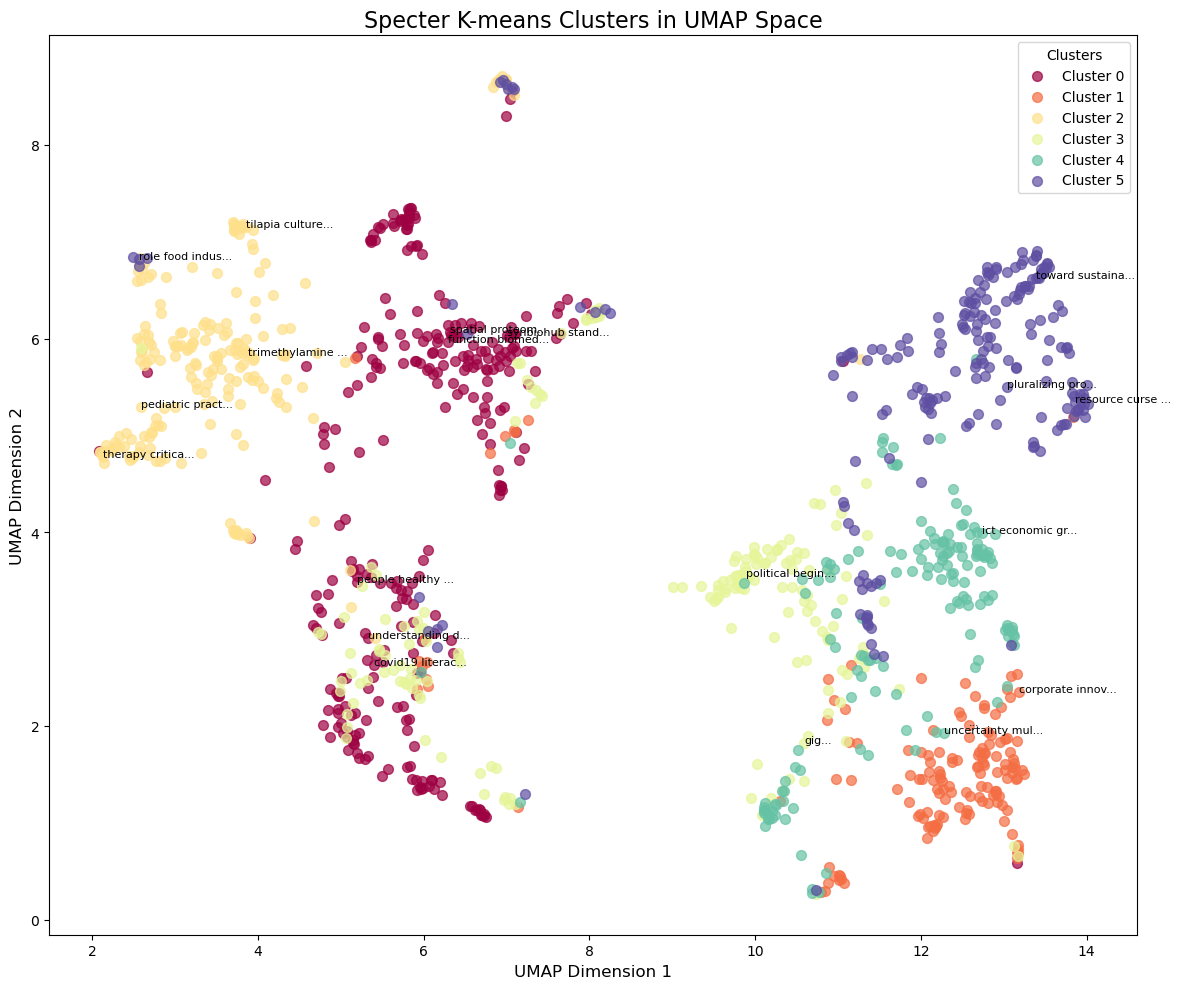

In [46]:
# @title Step 7: FAISS K-means Clustering
num_clusters = 6  # Change this based on your dataset
faiss_kmeans = faiss.Kmeans(d=embeddings_np.shape[1], k=num_clusters, niter=20, verbose=True)

# Train the clustering model
faiss_kmeans.train(embeddings_np)

# Get cluster centroids
centroids = faiss_kmeans.centroids  # Shape: (num_clusters, embedding_dim)

# Assign each embedding to the closest cluster
index_clustering = faiss.IndexFlatIP(embeddings_np.shape[1])
index_clustering.add(centroids)
_, labels = index_clustering.search(embeddings_np, 1)  # Use index_clustering instead of index

# labels contains the cluster assignment for each embedding
print("Cluster assignments:", labels.flatten())

# Plot the UMAP embeddings colored by FAISS K-means clusters
plt.figure(figsize=(12, 10))

# Get unique cluster labels from Faiss
faiss_labels = labels.flatten()  # Flatten the Faiss labels array
unique_clusters = np.unique(faiss_labels)
colors = plt.cm.Spectral(np.linspace(0, 1, len(unique_clusters)))

# Create a scatter plot for each cluster
for cluster_id, color in zip(unique_clusters, colors):
    # Get indices for current cluster
    mask = faiss_labels == cluster_id
    # Plot points in current cluster
    plt.scatter(umap_embeds[mask, 0], umap_embeds[mask, 1],
                c=[color], s=50, alpha=0.7, label=f'Cluster {cluster_id}')

# Add titles for a few points for context
num_titles = 20  # Number of titles to show
step = len(df) // num_titles
for i in range(0, len(df), step):
    if i < len(umap_embeds):  # Make sure we don't go out of bounds
        plt.annotate(df.iloc[i]['clean_title'][:15] + "...",
                    (umap_embeds[i, 0], umap_embeds[i, 1]),
                    fontsize=8)

plt.title('Specter K-means Clusters in UMAP Space', fontsize=16)
plt.xlabel('UMAP Dimension 1', fontsize=12)
plt.ylabel('UMAP Dimension 2', fontsize=12)

# Create a ScalarMappable with the colormap
sm = plt.cm.ScalarMappable(cmap='Spectral', norm=plt.Normalize(vmin=min(unique_clusters), vmax=max(unique_clusters)))
sm.set_array([])  # You need to set an array for the mappable
plt.legend(title='Clusters')
plt.tight_layout()
plt.show()

In [47]:
(
    adjusted_rand_score(encoded_values, faiss_labels),
    adjusted_mutual_info_score(encoded_values, faiss_labels)
)

(0.4274782500372329, 0.4984406933566114)

In [55]:
# Make sure to handle NaN values in the data
df_clean = df.fillna("")  # Fill NaN values with empty strings
title_abs = (df_clean['title'] + tokenizer.sep_token + df_clean['description']).tolist()

# Convert the text data to TF-IDF vectors
tfidf_vectorizer = TfidfVectorizer(stop_words='english')
tfidf_matrix = tfidf_vectorizer.fit_transform(title_abs)

# Apply K-Means clustering
num_clusters = 6
km = cluster.KMeans(n_clusters=num_clusters, random_state=42)
km.fit(tfidf_matrix)

# Assign each document to a cluster
clusters = km.labels_.tolist()

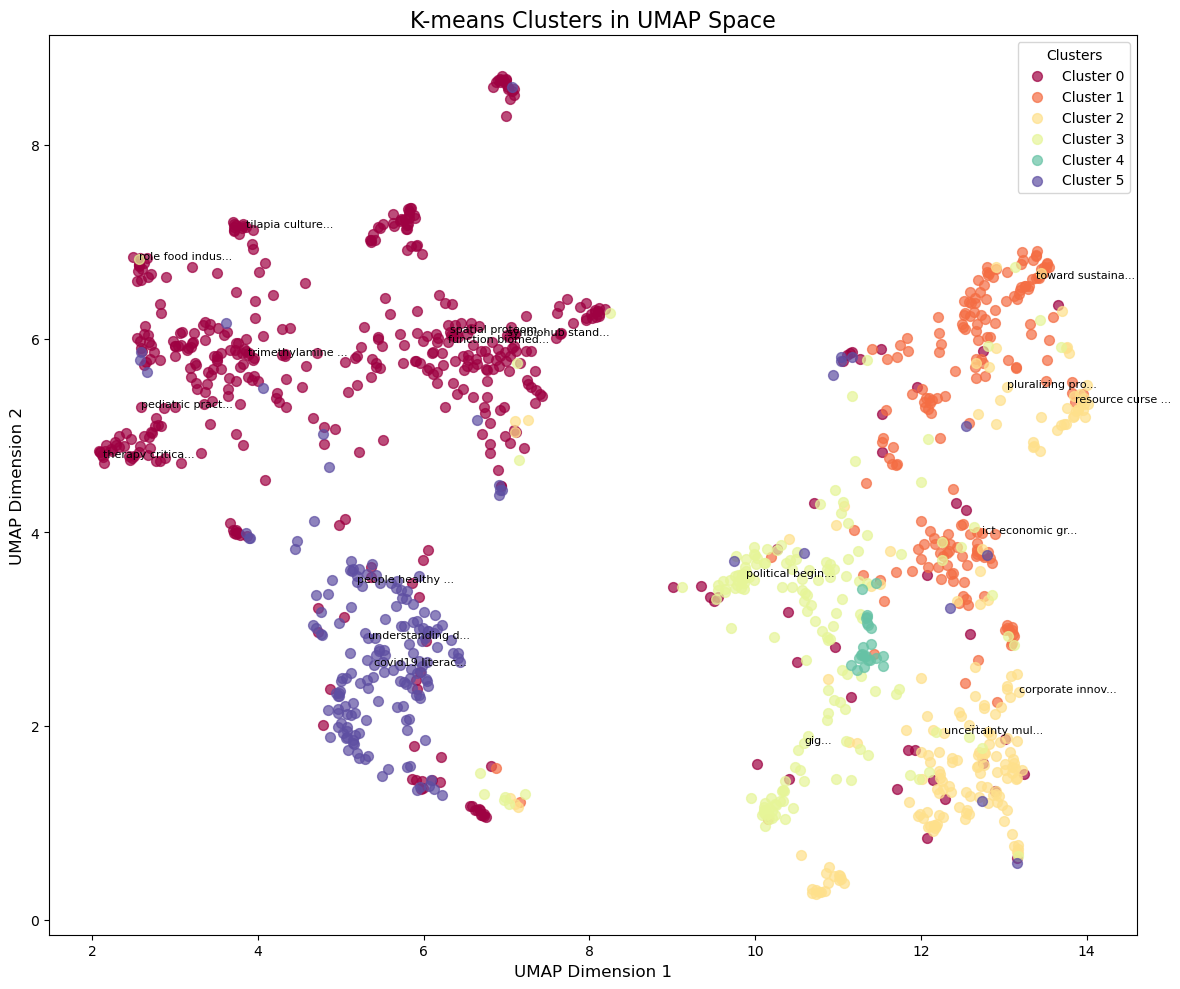

In [56]:
# Plot the UMAP embeddings colored by FAISS K-means clusters
plt.figure(figsize=(12, 10))

# Get unique cluster labels
unique_clusters = np.unique(km.labels_)
colors = plt.cm.Spectral(np.linspace(0, 1, len(unique_clusters)))

# Create a scatter plot for each cluster
for cluster_id, color in zip(unique_clusters, colors):
    # Get indices for current cluster
    mask = km.labels_ == cluster_id
    # Plot points in current cluster
    plt.scatter(umap_embeds[mask, 0], umap_embeds[mask, 1],
                c=[color], s=50, alpha=0.7, label=f'Cluster {cluster_id}')

# Add titles for a few points for context
num_titles = 20  # Number of titles to show
step = len(df) // num_titles
for i in range(0, len(df), step):
    if i < len(umap_embeds):  # Make sure we don't go out of bounds
        plt.annotate(df.iloc[i]['clean_title'][:15] + "...",
                    (umap_embeds[i, 0], umap_embeds[i, 1]),
                    fontsize=8)

plt.title('K-means Clusters in UMAP Space', fontsize=16)
plt.xlabel('UMAP Dimension 1', fontsize=12)
plt.ylabel('UMAP Dimension 2', fontsize=12)

# Create a ScalarMappable with the colormap
sm = plt.cm.ScalarMappable(cmap='Spectral', norm=plt.Normalize(vmin=min(unique_clusters), vmax=max(unique_clusters)))
sm.set_array([])  # You need to set an array for the mappable
plt.legend(title='Clusters')
plt.tight_layout()
plt.show()

In [57]:
(
    adjusted_rand_score(encoded_values, clusters),
    adjusted_mutual_info_score(encoded_values, clusters)
)

(0.6225184129203122, 0.7527132407388651)

In [51]:
def recommend_paper_tfidf(query_title, query_description, df, top_k=3):
    # Prepare the data if not already done
    if not hasattr(recommend_paper_tfidf, 'tfidf_vectorizer'):
        # Combine title and description for each paper in the dataset
        corpus = [str(row['clean_title']) + " " + str(row['description']) for _, row in df.iterrows()]
        
        # Create and fit TF-IDF vectorizer
        recommend_paper_tfidf.tfidf_vectorizer = TfidfVectorizer(stop_words='english', max_features=1024)
        recommend_paper_tfidf.tfidf_matrix = recommend_paper_tfidf.tfidf_vectorizer.fit_transform(corpus)
        
        # Create FAISS index
        recommend_paper_tfidf.index = faiss.IndexFlatIP(recommend_paper_tfidf.tfidf_matrix.shape[1])
        # Convert sparse matrix to dense and normalize
        vectors = recommend_paper_tfidf.tfidf_matrix.toarray().astype('float32')
        faiss.normalize_L2(vectors)
        recommend_paper_tfidf.index.add(vectors)

    # Combine query title and description
    query_text = str(query_title) + " " + str(query_description)
    
    # Transform the query using the same vectorizer
    query_vector = recommend_paper_tfidf.tfidf_vectorizer.transform([query_text])
    
    # Convert to dense array and normalize
    query_vector_dense = query_vector.toarray().astype('float32')
    faiss.normalize_L2(query_vector_dense)
    
    # Search the index
    distances, indices = recommend_paper_tfidf.index.search(query_vector_dense, top_k)
    
    print(f"🔍 Recommendations for '{query_title}':")
    for i, idx in enumerate(indices[0]):
        citation_value = df.iloc[idx].get('citations', 'N/A')
        print(f"{i+1}. {df.iloc[idx]['title']} (Citations: {citation_value})")
        description = str(df.iloc[idx]['description'])[:100] if pd.notna(df.iloc[idx]['description']) else "No description available"
        print(f"   {description}...\n")

# Example usage:
recommend_paper_tfidf(
    query_title="Air pollutants, economic growth and public health",
    query_description="and economic growth. Moreover, most studies use GDP as a proxy for economic growth",
    df=df,
    top_k=10
)

🔍 Recommendations for 'Air pollutants, economic growth and public health':
1. Air pollutants, economic growth and public health: implications for sustainable development in OECD countries (Citations: 116)
   … and economic growth. Moreover, most studies use GDP as a proxy for economic growth; 
current … use...

2. IPCC baseline scenarios have over-projected CO2 emissions and economic growth (Citations: 152)
   … Future economic growth is … GDP growth will catch up to baselines before mid-century. Some 
expert...

3. Air transport and economic growth: a review of the impact mechanism and causal relationships (Citations: 235)
   … from air transport to economic growth. Especially … that economic growth causally leads to 
air tr...

4. Entrepreneurship and economic growth (Citations: 33)
   … Monitor, GEM) affect the economic activity in a given country (as … GDP growth considers that 
a r...

5. Growth and distribution (Citations: 792)
   … The focus of the book was then on explaining th